In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from shearnet.dataset import generate_dataset
from tqdm import tqdm

# Set parameters
num_samples = 100  # Set this to 10000 or more for thousands of images
psf_fwhm = 1.0      # PSF full width at half maximum

# Generate dataset for the ideal PSF model
images_ideal, labels_ideal, obs_list = generate_dataset(num_samples, psf_fwhm, exp='ideal', return_obs=True)

100%|██████████| 100/100 [00:01<00:00, 84.11it/s]


In [12]:
from shearnet import ngmix

seed = 42

prior = ngmix._get_priors(seed)
rng = np.random.RandomState(seed)

data_list = ngmix.mp_fit_one(obs_list, prior, rng, psf_model='gauss', gal_model='gauss')

Using 18 cores out of 8 available.


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


In [33]:
data_list[99][0][3][1]

np.float64(0.47337980773289495)

In [19]:
data_list[99][0]

np.void((0, 'noshear', 2931.233746621356, [0.24509982788529772, 0.47337980773289495], 3.9050713391247993, 1.1664102799220626, 2.0873682970621594, [[2.0560824664380994e-08, 5.4763328326090925e-09], [5.4763328326090925e-09, 2.8282019959295442e-08]]), dtype=[('flags', '<i4'), ('shear_type', '<U7'), ('s2n', '<f8'), ('g', '<f8', (2,)), ('T', '<f8'), ('flux', '<f8'), ('Tpsf', '<f8'), ('g_cov', '<f8', (2, 2))])

In [4]:
labels_ideal[99]

array([0.24456339, 0.47282904, 1.0444463 , 1.1661321 ], dtype=float32)

In [27]:
g1_Rinv[99], g2_Rinv[99]

(np.float64(0.23869019428686455), np.float64(0.47103446748704003))

In [5]:
mcal_shear = 0.01

r11_list, r22_list, r12_list, r21_list, c1_list, c2_list, c1_psf_list, c2_psf_list = ngmix.response_calculation(data_list, mcal_shear)

100%|██████████| 100/100 [00:00<00:00, 52135.54it/s]


In [22]:
g_noshear_list = []
g_cov_noshear_list = []
T_noshear_list = []
Tpsf_noshear_list = []
for i in tqdm(range(len(obs_list))):
    g_noshear = data_list[i][0][3]
    T_noshear = data_list[i][0][4]
    flux_noshear = data_list[i][0][5]
    Tpsf_noshear = data_list[i][0][6]
    g_cov_noshear = data_list[i][0][7]
    g_noshear_list.append(g_noshear)
    T_noshear_list.append(T_noshear)
    Tpsf_noshear_list.append(Tpsf_noshear)
    g_cov_noshear_list.append(g_cov_noshear)

# Convert lists to NumPy arrays
r11_array = np.array(r11_list)
r22_array = np.array(r22_list)
r12_array = np.array(r12_list)
r21_array = np.array(r21_list)
c1_array = np.array(c1_list)
c2_array = np.array(c2_list)
c1_psf_array = np.array(c1_psf_list)
c2_psf_array = np.array(c2_psf_list)
g_noshear_array = np.array(g_noshear_list)
g_cov_noshear_array = np.array(g_cov_noshear_list)
T_noshear_array = np.array(T_noshear_list)
Tpsf_noshear_array = np.array(Tpsf_noshear_list)

R_gamma = np.array([[np.mean(r11_array), np.mean(r12_array)], 
                    [np.mean(r21_array), np.mean(r22_array)]])

c_psf = np.array([np.mean(c1_psf_array), np.mean(c1_psf_array)])
c_gamma = np.array([np.mean(c1_array), np.mean(c2_array)])

# Check if R_gamma is invertible
if np.linalg.det(R_gamma) == 0:
    print("\nWarning: R_gamma is singular (non-invertible). Using pseudo-inverse instead.")
    R_inv = np.linalg.pinv(R_gamma)  # Use pseudo-inverse to avoid errors
else:
    R_inv = np.linalg.inv(R_gamma)

c_total = c_psf + c_gamma

# Print results
print("\nGamma Response Matrix (R_gamma):")
print(R_gamma)

print("\nPSF Correction Vector (c_psf):")
print(c_psf)

print("\nGamma Correction Vector (c_gamma):")
print(c_gamma)

print("\nInverse of Gamma Response Matrix (R_inv):")
print(R_inv)


100%|██████████| 100/100 [00:00<00:00, 79815.49it/s]


Gamma Response Matrix (R_gamma):
[[1.00673562 0.01834928]
 [0.01839578 1.00381261]]

PSF Correction Vector (c_psf):
[-0.00384231 -0.00384231]

Gamma Correction Vector (c_gamma):
[1.08068684e-06 8.88873746e-07]

Inverse of Gamma Response Matrix (R_inv):
[[ 0.99364134 -0.01816335]
 [-0.01820938  0.99653473]]


In [23]:
g1_Rinv, g2_Rinv = [], []
for i in tqdm(range(len(g_noshear_list))):
    g_noshear = g_noshear_list[i]
    g_biased = g_noshear - c_total
    g_corrected = np.einsum('ij,nj->ni', R_inv, g_biased[np.newaxis, :]).squeeze()
    #g_corrected[0] = g_biased[0]/np.mean(r11_clean)
    #g_corrected[1] = g_biased[1]/np.mean(r22_clean)
    g1_Rinv.append(g_corrected[0])
    g2_Rinv.append(g_corrected[1])

100%|██████████| 100/100 [00:00<00:00, 53025.34it/s]


(np.float64(0.23869019428686455), np.float64(0.47103446748704003))

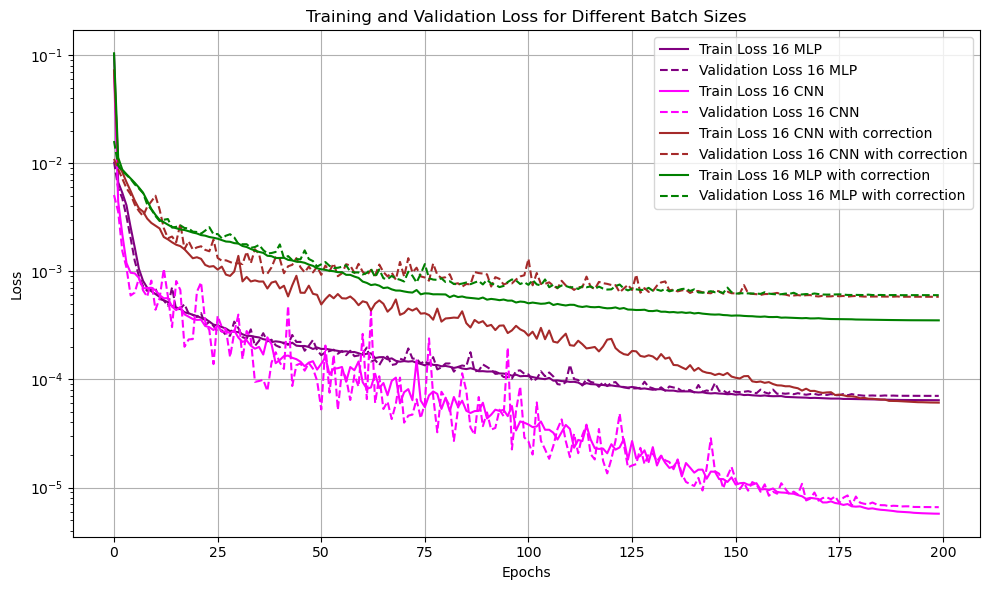

In [35]:
import numpy as np

# Load the .npz file
data1 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/dense1/dense1_loss.npz')
data2 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/dense2/dense2_loss.npz')
data3 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/dense3/dense3_loss.npz')
data4 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/dense4/dense4_loss.npz')
data5 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/dense5/dense5_loss.npz')
data1_2 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/dense6/dense6_loss.npz')
data_cnn1 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/cnn1/cnn1_loss.npz')
data_cnn2 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/cnn2/cnn2_loss.npz')
data_cnn3 = np.load('/Users/sayan/SuperBIT/sayan_repo/.shearnet/plots/cnn3/cnn3_loss.npz')
# See what arrays are stored in it

train256 = data1['train_loss']
val256 = data1['val_loss']
train128 = data2['train_loss']
val128 = data2['val_loss']
train64 = data3['train_loss']
val64 = data3['val_loss']
train32 = data4['train_loss']
val32 = data4['val_loss']
train16 = data5['train_loss']
val16 = data5['val_loss']
train1_2 = data1_2['train_loss']
val1_2 = data1_2['val_loss']
train256_cnn = data_cnn1['train_loss']
val256_cnn = data_cnn1['val_loss']
train16_cnn = data_cnn2['train_loss']
val16_cnn = data_cnn2['val_loss']
train16_cnn1 = data_cnn3['train_loss']
val16_cnn1 = data_cnn3['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
#plt.plot(train256, label='Train Loss 256 MLP', color='blue')
#plt.plot(val256, label='Validation Loss 256 MLP', color='blue', linestyle='--')
#plt.plot(train256_cnn, label='Train Loss 256 CNN', color='cyan')
#plt.plot(val256_cnn, label='Validation Loss 256 CNN', color='cyan', linestyle='--')

#plt.plot(train128, label='Train Loss 128', color='orange')
#plt.plot(val128, label='Validation Loss 128', color='orange', linestyle='--')
#plt.plot(train64, label='Train Loss 64', color='green')
#plt.plot(val64, label='Validation Loss 64', color='green', linestyle='--')
#plt.plot(train32, label='Train Loss 32', color='red')
#plt.plot(val32, label='Validation Loss 32', color='red', linestyle='--')
plt.plot(train16, label='Train Loss 16 MLP', color='purple')
plt.plot(val16, label='Validation Loss 16 MLP', color='purple', linestyle='--')

plt.plot(train16_cnn, label='Train Loss 16 CNN', color='magenta')
plt.plot(val16_cnn, label='Validation Loss 16 CNN', color='magenta', linestyle='--')

plt.plot(train16_cnn1, label='Train Loss 16 CNN with correction', color='brown')
plt.plot(val16_cnn1, label='Validation Loss 16 CNN with correction', color='brown', linestyle='--')

plt.plot(train1_2, label='Train Loss 16 MLP with correction', color='green')
plt.plot(val1_2, label='Validation Loss 16 MLP with correction', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Batch Sizes')
plt.legend()
plt.grid()
plt.yscale('log')
plt.tight_layout()


In [21]:
import matplotlib.patches as patches

def create_architecture_diagram(save_path='architecture.png'):
    """Create a visual diagram of the network architecture"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 12))
    
    # Define layers with their properties
    layers = [
        {'name': 'Input\n53×53×1', 'color': 'lightblue', 'width': 0.8},
        {'name': 'Conv2D\n3×3, 16\n53×53×16', 'color': 'lightgreen', 'width': 0.8},
        {'name': 'ReLU', 'color': 'yellow', 'width': 0.6},
        {'name': 'AvgPool\n2×2\n26×26×16', 'color': 'orange', 'width': 0.8},
        {'name': 'Conv2D\n3×3, 32\n26×26×32', 'color': 'lightgreen', 'width': 0.8},
        {'name': 'ReLU', 'color': 'yellow', 'width': 0.6},
        {'name': 'AvgPool\n2×2\n13×13×32', 'color': 'orange', 'width': 0.8},
        {'name': 'Flatten\n5408', 'color': 'pink', 'width': 0.8},
        {'name': 'Dense\n128', 'color': 'lightcoral', 'width': 0.8},
        {'name': 'ReLU', 'color': 'yellow', 'width': 0.6},
        {'name': 'Dense\n4', 'color': 'lightcoral', 'width': 0.8},
        {'name': 'Output\n[g1, g2, σ, flux]', 'color': 'lightblue', 'width': 0.8},
    ]
    
    # Draw layers
    y_pos = 0.9
    layer_height = 0.06
    layer_spacing = 0.01
    
    for i, layer in enumerate(layers):
        # Create rectangle for layer
        rect = patches.Rectangle(
            (0.5 - layer['width']/2, y_pos - layer_height),
            layer['width'], layer_height,
            linewidth=2, edgecolor='black',
            facecolor=layer['color']
        )
        ax.add_patch(rect)
        
        # Add text
        ax.text(0.5, y_pos - layer_height/2, layer['name'],
                ha='center', va='center', fontsize=10, weight='bold')
        
        # Draw arrow to next layer
        if i < len(layers) - 1:
            ax.arrow(0.5, y_pos - layer_height - 0.005,
                    0, -layer_spacing + 0.01,
                    head_width=0.03, head_length=0.01,
                    fc='black', ec='black')
        
        y_pos -= (layer_height + layer_spacing)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Galaxy Parameter Estimation CNN Architecture', fontsize=16, weight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

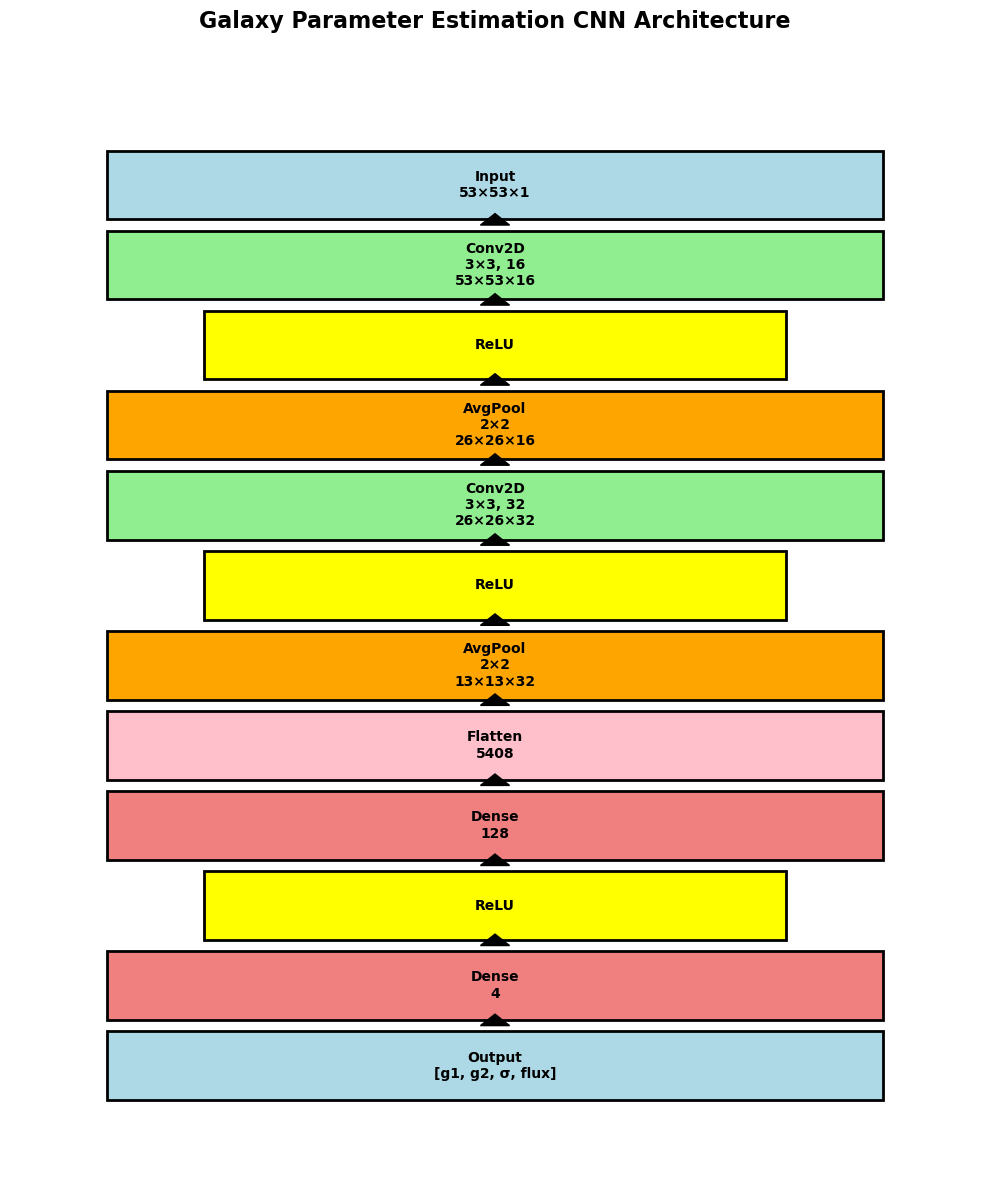

In [22]:
create_architecture_diagram()